# Classification 1 (LDA & QDA)

Ex 1: LDA and QDA with covariance ellipsoid

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import numpy as np
from scipy import linalg

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
plt.cm.register_cmap(cmap=cmap)

In [27]:
def dataset_fixed_cov():
    """Generate 2 Gaussians samples with the same covariance matrix"""
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -0.23], [0.83, 0.23]])
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C) + np.array([1, 1]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    """Generate 2 Gaussians samples with different covariance matrices"""
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -1.0], [2.5, 0.7]]) * 2.0
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

In [28]:
from scipy import linalg


def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title("Linear Discriminant Analysis")
        plt.ylabel("Data with\n fixed covariance")
    elif fig_index == 2:
        plt.title("Quadratic Discriminant Analysis")
    elif fig_index == 3:
        plt.ylabel("Data with\n varying covariances")

    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000")  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
    plt.scatter(
        X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099"
    )  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # means
    plt.plot(
        lda.means_[0][0],
        lda.means_[0][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    plt.plot(
        lda.means_[1][0],
        lda.means_[1][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, "red")
    plot_ellipse(splot, lda.means_[1], lda.covariance_, "blue")


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], "red")
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], "blue")

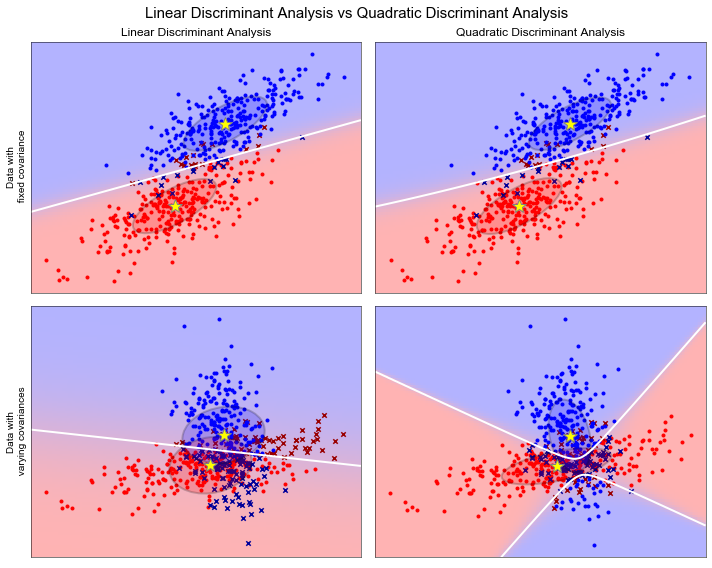

In [29]:
plt.figure(figsize=(10, 8), facecolor="white")
plt.suptitle(
    "Linear Discriminant Analysis vs Quadratic Discriminant Analysis",
    y=0.98,
    fontsize=15,
)
for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis("tight")

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis("tight")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

Ex 2: Vowel Speech Recognition

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

np.warnings.filterwarnings('ignore')
%matplotlib inline

# set common plots properties and define commonly used colors
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
BLUE, ORANGE, GRAY1, GRAY4 = '#57B5E8', '#E69E00', '#231F20', '#646369'


In [31]:
# load training and test data sets from the file
df = pd.read_csv("../data/Vowel.txt")
# rename classes to be in range 0-10
df.y = df.y - 1
df.head()

,row.names,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,is_train
0,1,0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,1
1,2,1,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,1
2,3,2,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,1
3,4,3,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,1
4,5,4,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,1


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row.names  990 non-null    int64  
 1   y          990 non-null    int64  
 2   x.1        990 non-null    float64
 3   x.2        990 non-null    float64
 4   x.3        990 non-null    float64
 5   x.4        990 non-null    float64
 6   x.5        990 non-null    float64
 7   x.6        990 non-null    float64
 8   x.7        990 non-null    float64
 9   x.8        990 non-null    float64
 10  x.9        990 non-null    float64
 11  x.10       990 non-null    float64
 12  is_train   990 non-null    int64  
dtypes: float64(10), int64(3)
memory usage: 100.7 KB


In [51]:
df.describe()

,row.names,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,is_train
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,249.100000,5.000000,-3.203740,1.881764,-0.507770,0.515483,-0.305658,0.630244,-0.004365,0.336553,-0.302976,-0.071339,0.533333
std,144.855624,3.163876,0.868987,1.175272,0.711948,0.759261,0.664602,0.603871,0.461927,0.573302,0.570162,0.603985,0.499140
min,1.000000,0.000000,-5.211000,-1.274000,-2.487000,-1.409000,-2.127000,-0.836000,-1.537000,-1.293000,-1.613000,-1.680000,0.000000
25%,124.250000,2.000000,-3.887750,1.051500,-0.975750,-0.065500,-0.769000,0.196000,-0.307000,-0.095750,-0.704000,-0.548000,0.000000
50%,248.000000,5.000000,-3.145500,1.876500,-0.572500,0.433500,-0.299000,0.552000,0.022000,0.328000,-0.302500,-0.156500,1.000000
75%,371.750000,8.000000,-2.602500,2.738000,-0.068750,1.096000,0.169500,1.028500,0.296500,0.770000,0.093750,0.371000,1.000000
max,528.000000,10.000000,-0.941000,5.074000,1.431000,2.377000,1.831000,2.327000,1.403000,2.039000,1.309000,1.396000,1.000000


In [2]:
features = [f'x.{i+1}' for i in range(10)]
features

['x.1', 'x.2', 'x.3', 'x.4', 'x.5', 'x.6', 'x.7', 'x.8', 'x.9', 'x.10']

In [3]:
# split the data into training and test sets based on the flag
df_train, df_test = df[df.is_train == 1], df[df.is_train == 0]
X_train, y_train = df_train[features].values, df_train.y.values
X_test, y_test = df_test[features].values, df_test.y.values
print(X_train.shape)
print(X_test.shape)

NameError: name 'df' is not defined

In [34]:
np.unique(y_train, return_counts= True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48], dtype=int64))

In [35]:
lda = LinearDiscriminantAnalysis(n_components=2).fit(X_train, y_train)
lda_train_acc = accuracy_score(y_train, lda.predict(X_train))
lda_test_acc = accuracy_score(y_test, lda.predict(X_test))
print(f'train acc of LDA: {lda_train_acc:.2f} and test acc of LDA: {lda_test_acc:.2f}')

train acc of LDA: 0.68 and test acc of LDA: 0.44


In [36]:
X_reduced = lda.transform(X_train)
print(X_reduced.shape)
print(X_reduced)

(528, 2)
[[-1.47922478 -2.8606636 ]
 [-1.12193444 -2.71328851]
 [-2.51456439  1.21813271]
 ...
 [ 2.32653902 -0.26344311]
 [ 3.20679752  0.53488706]
 [ 0.28285334 -1.51530678]]


In [37]:
means = lda.transform(lda.means_)
print(means.shape)
print(means)

(11, 2)
[[-2.00547372 -2.98844022]
 [-1.98934936 -1.3899611 ]
 [-2.59519437  0.29549256]
 [-2.04291492  2.02396774]
 [ 0.29068139  1.95082659]
 [-0.57084162  1.35133553]
 [ 1.46803376  1.22171582]
 [ 3.37921329  0.50455849]
 [ 1.9718431  -1.09401547]
 [ 2.57837833 -1.92706082]
 [-0.48437587  0.05158086]]


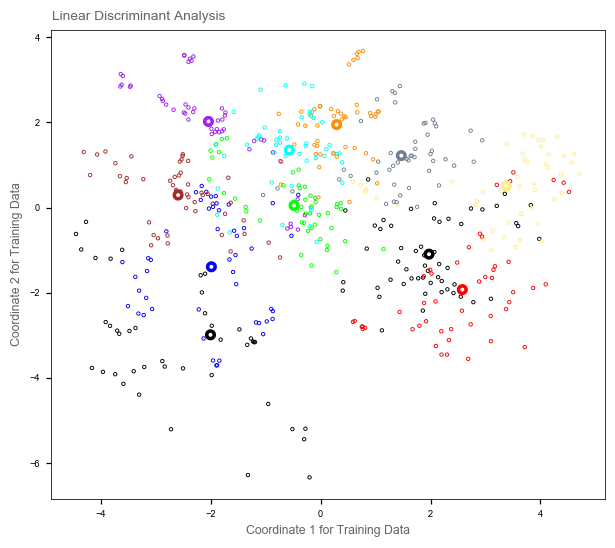

In [38]:
# define colors for classes
colors = np.array([
    '#000000', '#0000FF', '#A52A2A', '#A020F0', '#FF8C00', '#00FFFF',
    '#708090', '#FFEC8B', '#000000', '#FF0000', '#00FF00'])
fig, ax = plt.subplots(figsize=(6.5, 5.65), dpi=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], facecolors='none',
           edgecolors=colors[y_train], s=5, linewidth=0.6)
ax.scatter(means[:, 0], means[:, 1], facecolors='none', edgecolors=colors,
           s=5, linewidth=5)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
ax.text(-4.89, 4.4, 'Linear Discriminant Analysis', color=GRAY4, fontsize=9)
ax.set_xlabel('Coordinate 1 for Training Data', color=GRAY4, fontsize=8)
_ = ax.set_ylabel('Coordinate 2 for Training Data', color=GRAY4, fontsize=8)

In [39]:
# Getting back to the general discriminant problem (4.8), if the Σk
# are not assumed to be equal, then the convenient cancellations in
# do not occur; in particular the pieces quadratic in x remain.
# We then get quadratic discriminant functions (QDA).
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
qda_train_acc = accuracy_score(y_train, qda.predict(X_train))
qda_test_acc = accuracy_score(y_test, qda.predict(X_test))
print(f'train acc of LDA: {qda_train_acc:.2f} and test acc of LDA: {qda_test_acc:.2f}')

train acc of LDA: 0.99 and test acc of LDA: 0.47


Ex 3: Iris Data

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [41]:
iris = load_iris().data
iris = pd.DataFrame(iris, columns 
                    = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width'])
iris['class'] = load_iris().target
iris.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [42]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal-length  150 non-null    float64
 1   sepal-width   150 non-null    float64
 2   petal-length  150 non-null    float64
 3   petal-width   150 non-null    float64
 4   class         150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [43]:
iris['class'].value_counts()

2    50
1    50
0    50
Name: class, dtype: int64

In [44]:
iris.describe()

,sepal-length,sepal-width,petal-length,petal-width,class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


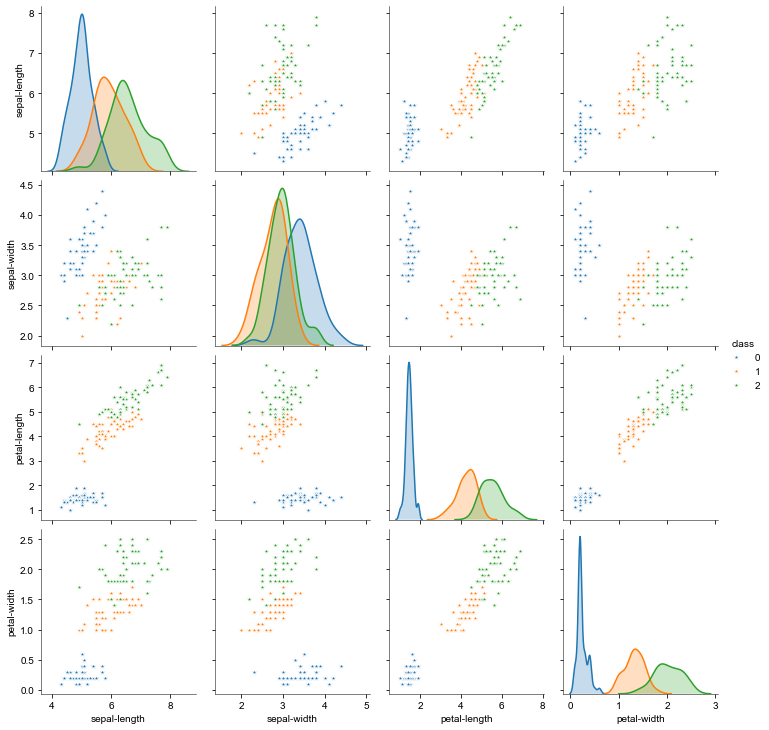

In [45]:
# Use Pairplot to understand relationships among paramaters
_ = sns.pairplot(iris, hue='class', markers='*')
plt.show()

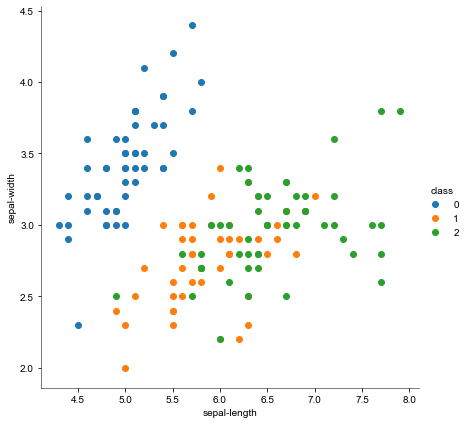

In [46]:
# We will use FacetGrid with scatter to understand better our dataset
_ = sns.FacetGrid(iris, hue="class", size=6) \
   .map(plt.scatter, "sepal-length", "sepal-width") \
   .add_legend()

In [47]:
X = iris.drop('class', axis = 1)
y = iris['class']

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size = 0.4, random_state = 11)

print(X_train.shape)
print(X_test.shape)

(90, 4)
(60, 4)


In [48]:
lda_model = LinearDiscriminantAnalysis(n_components=2)
lda_model.fit(X_train, y_train)
y_pred = lda_model.predict(X_test)
y_train_pred= lda_model.predict(X_train)

print('The accuracy of train data is',
          metrics.accuracy_score(y_train, y_train_pred))
print('The accuracy of test data is',
          metrics.accuracy_score(y_test, y_pred))

The accuracy of train data is 0.9888888888888889
The accuracy of test data is 0.95


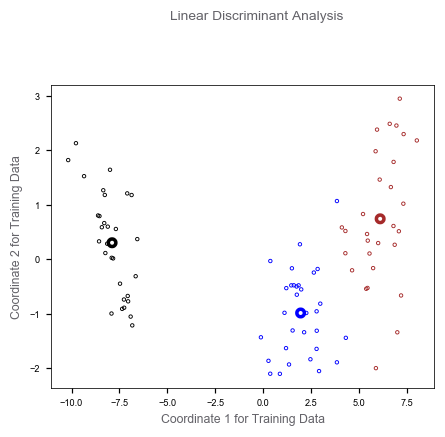

In [49]:
X_reduced = lda_model.transform(X_train)
means = lda_model.transform(lda_model.means_)

# define colors for classes
colors = np.array([
    '#000000', '#0000FF', '#A52A2A'])
fig, ax = plt.subplots(figsize=(4.5, 3.65), dpi=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], facecolors='none',
           edgecolors=colors[y_train], s=5, linewidth=0.6)
ax.scatter(means[:, 0], means[:, 1], facecolors='none', edgecolors=colors,
           s=5, linewidth=5)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
ax.text(-4.89, 4.4, 'Linear Discriminant Analysis', color=GRAY4, fontsize=9)
ax.set_xlabel('Coordinate 1 for Training Data', color=GRAY4, fontsize=8)
_ = ax.set_ylabel('Coordinate 2 for Training Data', color=GRAY4, fontsize=8)

In [50]:
qda_model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
y_pred_qda = qda_model.predict(X_test)
y_train_pred_qda= qda_model.predict(X_train)

print('The accuracy of train data is',
          metrics.accuracy_score(y_train, y_train_pred_qda))
print('The accuracy of test data is',
          metrics.accuracy_score(y_test, y_pred_qda))

The accuracy of train data is 0.9888888888888889
The accuracy of test data is 0.9833333333333333
